In [1]:
%matplotlib inline

In [2]:
import os, sys
import glob
import re
import math
import time
import numpy as np
from uncertainties import unumpy as unp
import uncertainties.umath as umath
import matplotlib.pyplot as plt
import pandas as pd
from uncertainties import ufloat

In [102]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 1.5

In [103]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [104]:
# unit conversion
# 1 Ha = 4.3597482*e-18 J
# 1 angstrom = 1.0*10e-10 m
# 1 atomic unit = 1.66057*10e-27 kg
# 1 THz = 33.35641 cm-1
Ry_to_J = 2.17987 * 10**-18
Ha_to_J = Ry_to_J * 2.0
J_to_Ha = 1.0 / Ha_to_J
aumass_to_kg = 1.66054 * 10**-27
bohr_to_m = 5.29177210903 * 10**-11
bohr_to_ang = 0.529177210903
ang_to_bohr = 1.0 / bohr_to_ang
m_to_bohr = 1.0 / bohr_to_m
au_to_GPa = (4.359e-18) / (0.5291772e-10) ** 3 * (10**-9)
KBar_to_Ha_bohr = 10**8 * J_to_Ha / (m_to_bohr) ** 3
Ha_bohr_to_KBar = 1.0 / KBar_to_Ha_bohr
# au_to_GPa = 1 a.u. = 1 Hartree/(1 Bohr)^3 = (4.359e-18 J)/(0.5291772e-10 m)^3 * (10**-12)

In [105]:
try:
    import ipynb_path

    root_dir = os.path.dirname(ipynb_path.get())
except ModuleNotFoundError:
    root_dir = "/mnt/data/kosuke/45jQMC/XX"
os.chdir(root_dir)
root_dir

'/Users/kosuke/applications/jQMC/examples/example02'

In [118]:
# def read
def read_vmc_num_mcmc(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Total.*elapsed.*time.*for.*MCMC.*", line):
                num_gfmc_steps = float(line.split()[5])
                return num_gfmc_steps
        return np.nan

In [119]:
# def read
def read_lrdmc_num_branching(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Total.*GFMC.*time.*for.*", line):
                num_gfmc_steps = float(line.split()[4])
                return num_gfmc_steps
        return np.nan

In [120]:
# def read
def read_vmc_elapsed_time(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Net.*total.*time.*for.*MCMC.*", line):
                elapsed_time = float(line.split()[6])
                return elapsed_time
        return np.nan

In [121]:
# def read
def read_lrdmc_elapsed_time(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Net.*GFMC.*time.*without.*pre-compilations.*", line):
                elapsed_time = float(line.split()[6])
                return elapsed_time
        return np.nan

In [122]:
# def read
def read_num_MPI_processes(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*The.*number.*of.*MPI.*process.*", line):
                num_MPI_processes = int(float(line.split()[6]))
                return num_MPI_processes
        return np.nan

In [123]:
# def read
def read_num_nw_for_each_MPI(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*The.*number.*of.*walkers.*assigned.*for.*each.*MPI.*process.*", line):
                num_nw_for_each_MPI = int(float(line.split()[10]))
                return num_nw_for_each_MPI
        return np.nan

In [134]:
mol_list = ["01water_jqmc", "02acetic_acid_jqmc", "03benzene_jqmc", "04benzene_dimer_jqmc"]
mol_label_list = [r"Water ($N_e = 8$)", r"Acetic Acid ($N_e = 24$)", r"Benzene ($N_e = 30$)", r"Benzene dimer ($N_e = 60$)"]
mol_label2_list = [r"Water", r"Acetic Acid", r"Benzene", r"Benzene dimer"]

In [135]:
summary_vmc = {}

# files
out_vmc_cpu = "out_vmc0_on_cpu"
out_vmc_gpu = "out_vmc0_on_gpu"

for mol in mol_list:
    # dirs
    cpu_dirs = glob.glob(os.path.join(root_dir, mol, "on_cpu", "node_*"))
    gpu_dirs = glob.glob(os.path.join(root_dir, mol, "on_gpu", "node_*"))
    # cpu part, VMC
    vmc_num_mcmc_cpu_np = np.array([read_vmc_num_mcmc(os.path.join(cpu_dir, out_vmc_cpu)) for cpu_dir in cpu_dirs])
    vmc_elapsed_time_cpu_np = np.array([read_vmc_elapsed_time(os.path.join(cpu_dir, out_vmc_cpu)) for cpu_dir in cpu_dirs])
    vmc_num_MPI_processes_cpu_np = np.array(
        [read_num_MPI_processes(os.path.join(cpu_dir, out_vmc_cpu)) for cpu_dir in cpu_dirs]
    )
    print(vmc_num_MPI_processes_cpu_np)
    vmc_num_nw_for_each_MPI_cpu_np = np.array(
        [read_num_nw_for_each_MPI(os.path.join(cpu_dir, out_vmc_cpu)) for cpu_dir in cpu_dirs]
    )
    vmc_num_total_nw_cpu_np = vmc_num_MPI_processes_cpu_np * vmc_num_nw_for_each_MPI_cpu_np
    vmc_num_mcmc_num_walkers_per_sec_cpu_np = vmc_num_total_nw_cpu_np * vmc_num_mcmc_cpu_np / vmc_elapsed_time_cpu_np
    vmc_label_cpu_np = [
        f"({num_MPI}MPI, {num_nw}Nw)" for num_MPI, num_nw in zip(vmc_num_MPI_processes_cpu_np, vmc_num_nw_for_each_MPI_cpu_np)
    ]

    # GPU part, VMC
    vmc_num_mcmc_gpu_np = np.array([read_vmc_num_mcmc(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs])
    vmc_elapsed_time_gpu_np = np.array([read_vmc_elapsed_time(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs])
    vmc_num_MPI_processes_gpu_np = np.array(
        [read_num_MPI_processes(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs]
    )
    vmc_num_nw_for_each_MPI_gpu_np = np.array(
        [read_num_nw_for_each_MPI(os.path.join(gpu_dir, out_vmc_gpu)) for gpu_dir in gpu_dirs]
    )
    print(vmc_num_MPI_processes_gpu_np)
    vmc_num_total_nw_gpu_np = vmc_num_MPI_processes_gpu_np * vmc_num_nw_for_each_MPI_gpu_np
    vmc_num_mcmc_num_walkers_per_sec_gpu_np = vmc_num_total_nw_gpu_np * vmc_num_mcmc_gpu_np / vmc_elapsed_time_gpu_np
    vmc_label_gpu_np = [
        f"({num_MPI}MPI, {num_nw}Nw)" for num_MPI, num_nw in zip(vmc_num_MPI_processes_gpu_np, vmc_num_nw_for_each_MPI_gpu_np)
    ]

    summary_vmc[mol] = {
        # VMC CPU part
        "vmc_num_mcmc_cpu_np": vmc_num_mcmc_cpu_np,
        "vmc_elapsed_time_cpu_np": vmc_elapsed_time_cpu_np,
        "vmc_num_MPI_processes_cpu_np": vmc_num_MPI_processes_cpu_np,
        "vmc_num_nw_for_each_MPI_cpu_np": vmc_num_nw_for_each_MPI_cpu_np,
        "vmc_num_total_nw_cpu_np": vmc_num_total_nw_cpu_np,
        "vmc_num_mcmc_num_walkers_per_sec_cpu_np": vmc_num_mcmc_num_walkers_per_sec_cpu_np,
        "vmc_label_cpu_np": vmc_label_cpu_np,
        # VMC GPU part
        "vmc_num_mcmc_gpu_np": vmc_num_mcmc_gpu_np,
        "vmc_elapsed_time_gpu_np": vmc_elapsed_time_gpu_np,
        "vmc_num_MPI_processes_gpu_np": vmc_num_MPI_processes_gpu_np,
        "vmc_num_nw_for_each_MPI_gpu_np": vmc_num_nw_for_each_MPI_gpu_np,
        "vmc_num_total_nw_gpu_np": vmc_num_total_nw_gpu_np,
        "vmc_num_mcmc_num_walkers_per_sec_gpu_np": vmc_num_mcmc_num_walkers_per_sec_gpu_np,
        "vmc_label_gpu_np": vmc_label_gpu_np,
    }

[  4   1  30 120  10  20   2  60]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[  4  30 120  10  20   2  60]
[4 4 4 4 4 4 4 4 4 4]
[120]
[4 4 4 4 4 4 4 4 4 4]
[120]
[4 4 4 4 4 4 4 4 4]


In [136]:
summary_lrdmc = {}

# files
out_lrdmc_cpu = "out_lrdmc0_on_cpu"
out_lrdmc_gpu = "out_lrdmc0_on_gpu"

for mol in mol_list:
    # dirs
    cpu_dirs = glob.glob(os.path.join(root_dir, mol, "on_cpu", "node_*"))
    gpu_dirs = glob.glob(os.path.join(root_dir, mol, "on_gpu", "node_*"))
    # cpu part, LRDMC
    lrdmc_num_branching_cpu_np = np.array(
        [read_lrdmc_num_branching(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs]
    )
    lrdmc_elapsed_time_cpu_np = np.array(
        [read_lrdmc_elapsed_time(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs]
    )
    lrdmc_num_MPI_processes_cpu_np = np.array(
        [read_num_MPI_processes(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs]
    )
    lrdmc_num_nw_for_each_MPI_cpu_np = np.array(
        [read_num_nw_for_each_MPI(os.path.join(cpu_dir, out_lrdmc_cpu)) for cpu_dir in cpu_dirs]
    )
    lrdmc_num_total_nw_cpu_np = lrdmc_num_MPI_processes_cpu_np * lrdmc_num_nw_for_each_MPI_cpu_np
    lrdmc_num_projections_num_walkers_per_sec_cpu_np = (
        lrdmc_num_total_nw_cpu_np * lrdmc_num_branching_cpu_np / lrdmc_elapsed_time_cpu_np
    )
    lrdmc_label_cpu_np = [
        f"({num_MPI}MPI, {num_nw}Nw)"
        for num_MPI, num_nw in zip(lrdmc_num_MPI_processes_cpu_np, lrdmc_num_nw_for_each_MPI_cpu_np)
    ]

    # GPU part, LRDMC
    lrdmc_num_branching_gpu_np = np.array(
        [read_lrdmc_num_branching(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
    )
    lrdmc_elapsed_time_gpu_np = np.array(
        [read_lrdmc_elapsed_time(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
    )
    lrdmc_num_MPI_processes_gpu_np = np.array(
        [read_num_MPI_processes(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
    )
    lrdmc_num_nw_for_each_MPI_gpu_np = np.array(
        [read_num_nw_for_each_MPI(os.path.join(gpu_dir, out_lrdmc_gpu)) for gpu_dir in gpu_dirs]
    )
    lrdmc_num_total_nw_gpu_np = lrdmc_num_MPI_processes_gpu_np * lrdmc_num_nw_for_each_MPI_gpu_np
    lrdmc_num_projections_num_walkers_per_sec_gpu_np = (
        lrdmc_num_total_nw_gpu_np * lrdmc_num_branching_gpu_np / lrdmc_elapsed_time_gpu_np
    )
    lrdmc_label_gpu_np = [
        f"({num_MPI}MPI, {num_nw}Nw)"
        for num_MPI, num_nw in zip(lrdmc_num_MPI_processes_gpu_np, lrdmc_num_nw_for_each_MPI_gpu_np)
    ]

    summary_lrdmc[mol] = {
        # LRDMC CPU part
        "lrdmc_num_branching_cpu_np": lrdmc_num_branching_cpu_np,
        "lrdmc_elapsed_time_cpu_np": lrdmc_elapsed_time_cpu_np,
        "lrdmc_num_MPI_processes_cpu_np": lrdmc_num_MPI_processes_cpu_np,
        "lrdmc_num_nw_for_each_MPI_cpu_np": lrdmc_num_nw_for_each_MPI_cpu_np,
        "lrdmc_num_total_nw_cpu_np": lrdmc_num_total_nw_cpu_np,
        "lrdmc_num_projections_num_walkers_per_sec_cpu_np": lrdmc_num_projections_num_walkers_per_sec_cpu_np,
        "lrdmc_label_cpu_np": lrdmc_label_cpu_np,
        # LRDMC GPU part
        "lrdmc_num_branching_gpu_np": lrdmc_num_branching_gpu_np,
        "lrdmc_elapsed_time_gpu_np": lrdmc_elapsed_time_gpu_np,
        "lrdmc_num_MPI_processes_gpu_np": lrdmc_num_MPI_processes_gpu_np,
        "lrdmc_num_nw_for_each_MPI_gpu_np": lrdmc_num_nw_for_each_MPI_gpu_np,
        "lrdmc_num_total_nw_gpu_np": lrdmc_num_total_nw_gpu_np,
        "lrdmc_num_projections_num_walkers_per_sec_gpu_np": lrdmc_num_projections_num_walkers_per_sec_gpu_np,
        "lrdmc_label_gpu_np": lrdmc_label_gpu_np,
    }

speed-up by GPU for 01water_jqmc is 17.65.
speed-up by GPU for 02acetic_acid_jqmc is 19.39.
speed-up by GPU for 03benzene_jqmc is 22.40.
speed-up by GPU for 04benzene_dimer_jqmc is 33.72.


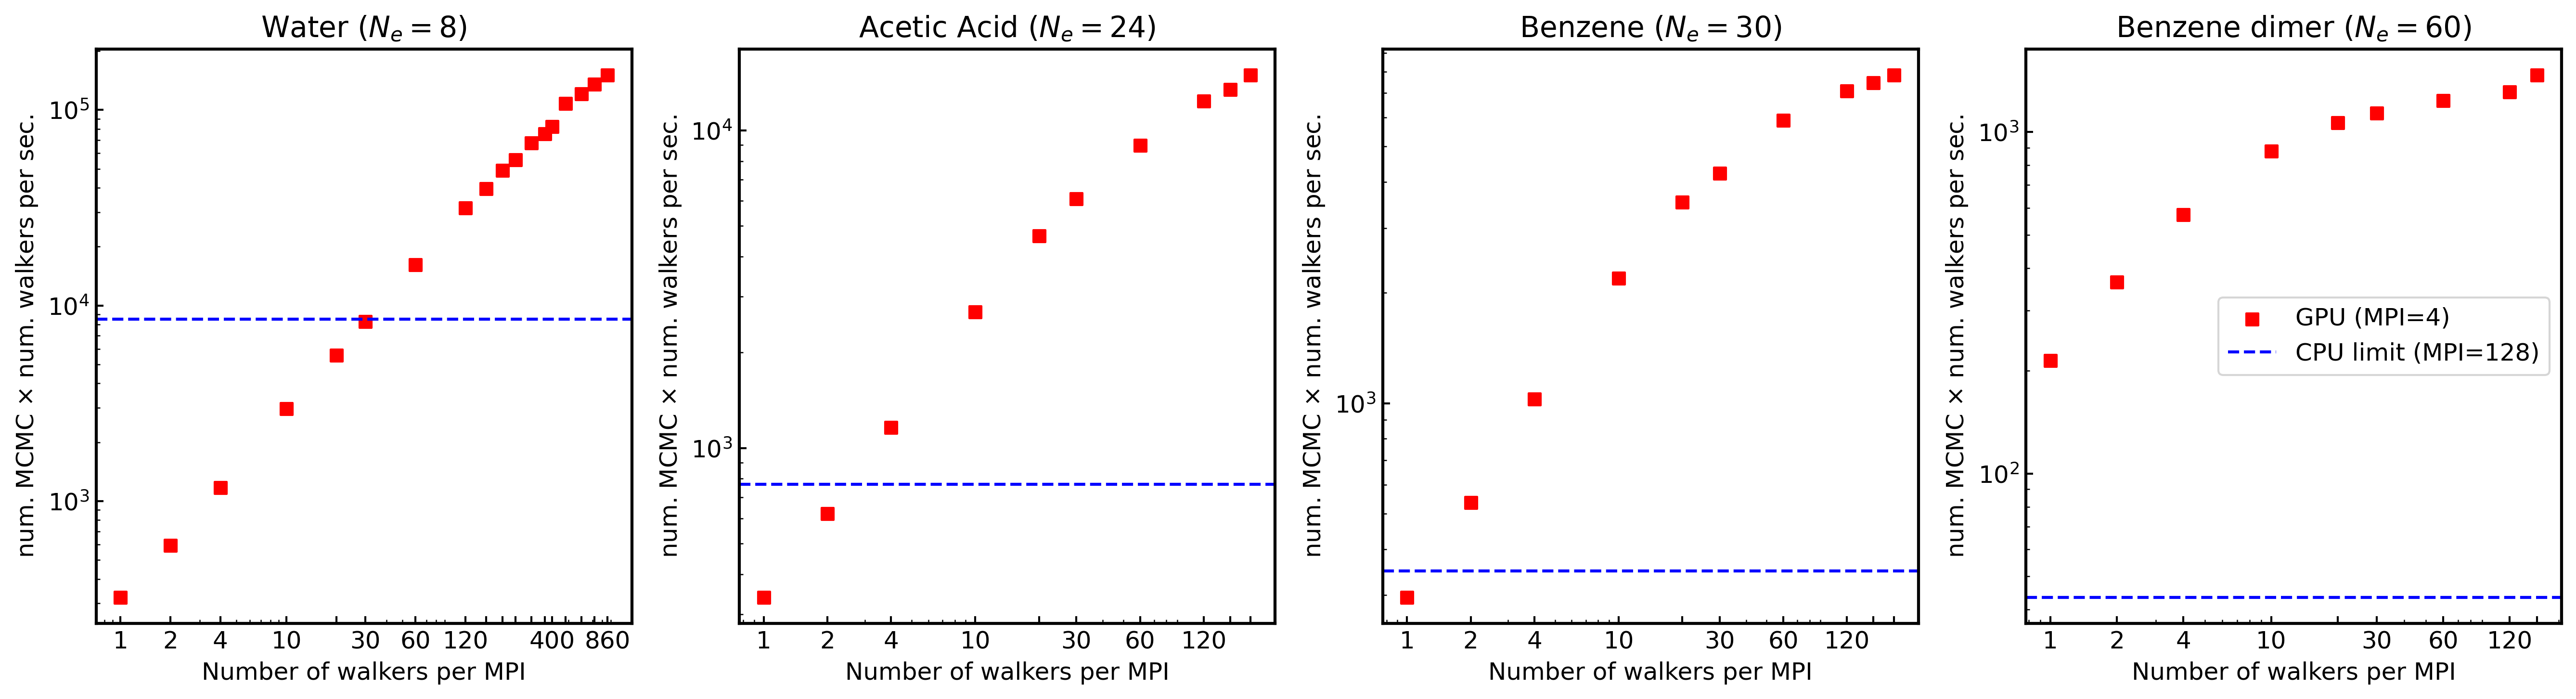

In [187]:
# plot Graph (VMC)
fig = plt.figure(figsize=(4.5 * len(mol_list), 5), facecolor="white", dpi=300, tight_layout=True)
# fig.suptitle(
#    rf"VMC implemented on jQMC, benchmarked on Xeon Platinum 8490H (60 cores) $\times$ 2 + NVIDIA H100 (Hopper) $\times$ 4",
#    fontsize=14,
# )

speed_up_jqmc_vmc_cpu = []
speed_up_jqmc_vmc_gpu = []

for i, mol in enumerate(mol_list):
    # plot Graph
    ax = fig.add_subplot(1, len(mol_list), i + 1)

    # labels
    ax.set_title(mol_label_list[i], wrap=True)
    ax.set_xlabel("Number of walkers per MPI")
    ax.set_ylabel(r"num. MCMC $\times$ num. walkers per sec.")
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax2.set_ylim([y_min, y_max])

    # GPU
    x = summary_vmc[mol]["vmc_num_nw_for_each_MPI_gpu_np"]
    y = summary_vmc[mol]["vmc_num_mcmc_num_walkers_per_sec_gpu_np"]
    ax.scatter(x, y, color="r", marker="s", label="GPU (MPI=4)")
    ax.axhline(
        np.max(summary_vmc[mol]["vmc_num_mcmc_num_walkers_per_sec_cpu_np"]), color="b", ls="--", label="CPU limit (MPI=128)"
    )
    ax.set_xticks(summary_vmc[mol]["vmc_num_nw_for_each_MPI_gpu_np"])
    xticklabels = [str(t) for t in summary_vmc[mol]["vmc_num_nw_for_each_MPI_gpu_np"]]
    xticklabels = [
        "" if item in ["20", "160", "200", "240", "300", "360", "480", "600", "720"] else item for item in xticklabels
    ]
    ax.set_xticklabels(xticklabels)

    speed_up_cpu = 1.0
    speed_up_gpu = np.max(summary_vmc[mol]["vmc_num_mcmc_num_walkers_per_sec_gpu_np"]) / np.max(
        summary_vmc[mol]["vmc_num_mcmc_num_walkers_per_sec_cpu_np"]
    )
    speed_up_jqmc_vmc_cpu.append(speed_up_cpu)
    speed_up_jqmc_vmc_gpu.append(speed_up_gpu)

    print(f"speed-up by GPU for {mol} is {speed_up_gpu:.2f}.")

plt.legend()
plt.savefig(f"jqmc_VMC_benchmark.jpg")
plt.show()

speed-up by GPU for 01water_jqmc is 18.18.
speed-up by GPU for 02acetic_acid_jqmc is 41.91.
speed-up by GPU for 03benzene_jqmc is 46.17.
speed-up by GPU for 04benzene_dimer_jqmc is 60.88.


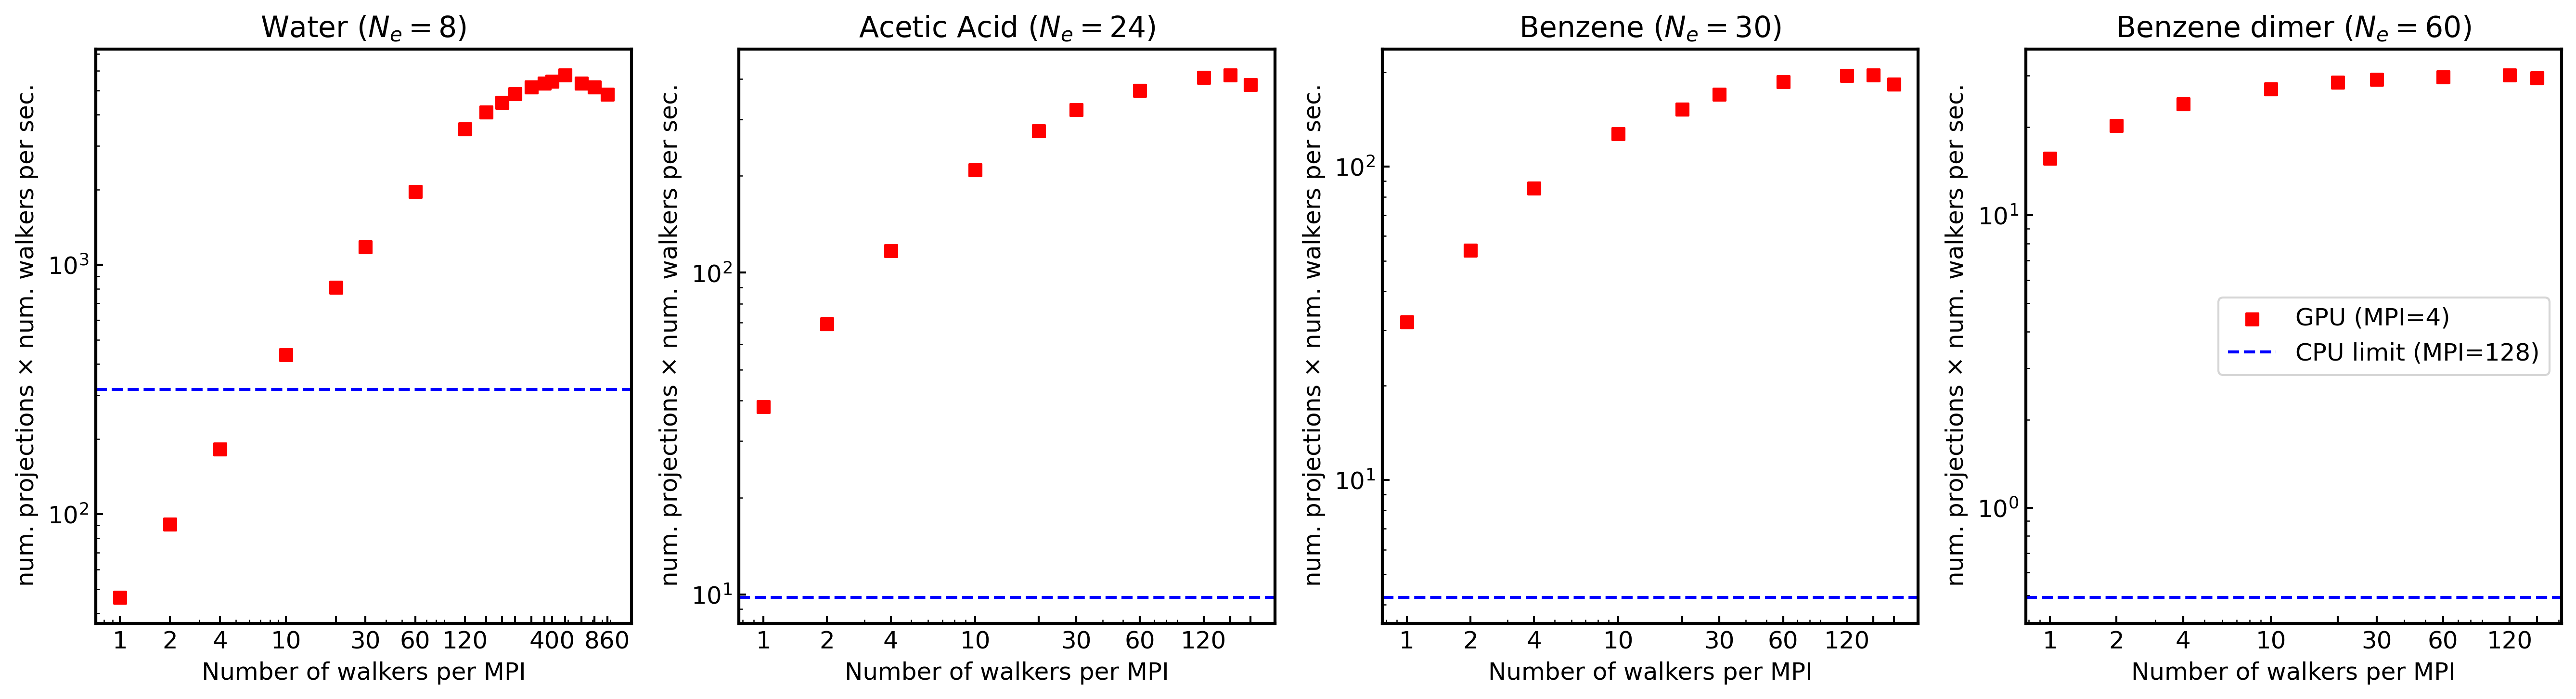

In [188]:
# plot Graph
fig = plt.figure(figsize=(4.5 * len(mol_list), 5), facecolor="white", dpi=300, tight_layout=True)
# fig.suptitle(
#    rf"LRDMC implemented on jQMC, benchmarked on Xeon Platinum 8490H (60 cores) $\times$ 2 + NVIDIA H100 (Hopper) $\times$ 4",
#    fontsize=14,
# )

speed_up_jqmc_lrdmc_cpu = []
speed_up_jqmc_lrdmc_gpu = []

for i, mol in enumerate(mol_list):
    # plot Graph
    ax = fig.add_subplot(1, len(mol_list), i + 1)

    # labels
    ax.set_title(mol_label_list[i], wrap=True)
    ax.set_xlabel("Number of walkers per MPI")
    ax.set_ylabel(r"num. projections $\times$ num. walkers per sec.")
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax2.set_ylim([y_min, y_max])

    # GPU
    x = summary_lrdmc[mol]["lrdmc_num_nw_for_each_MPI_gpu_np"]
    y = summary_lrdmc[mol]["lrdmc_num_projections_num_walkers_per_sec_gpu_np"]
    ax.scatter(x, y, color="r", marker="s", label="GPU (MPI=4)")
    ax.axhline(
        np.max(summary_lrdmc[mol]["lrdmc_num_projections_num_walkers_per_sec_cpu_np"]),
        color="b",
        ls="--",
        label="CPU limit (MPI=128)",
    )
    ax.set_xticks(summary_lrdmc[mol]["lrdmc_num_nw_for_each_MPI_gpu_np"])
    xticklabels = [str(t) for t in summary_lrdmc[mol]["lrdmc_num_nw_for_each_MPI_gpu_np"]]
    xticklabels = [
        "" if item in ["20", "160", "200", "240", "300", "360", "480", "600", "720"] else item for item in xticklabels
    ]
    ax.set_xticklabels(xticklabels)

    speed_up_cpu = 1.0
    speed_up_gpu = np.max(summary_lrdmc[mol]["lrdmc_num_projections_num_walkers_per_sec_gpu_np"]) / np.max(
        summary_lrdmc[mol]["lrdmc_num_projections_num_walkers_per_sec_cpu_np"]
    )
    speed_up_jqmc_lrdmc_cpu.append(speed_up_cpu)
    speed_up_jqmc_lrdmc_gpu.append(speed_up_gpu)

    print(f"speed-up by GPU for {mol} is {speed_up_gpu:.2f}.")

plt.legend()
plt.savefig(f"jqmc_LRDMC_benchmark.jpg")
plt.show()

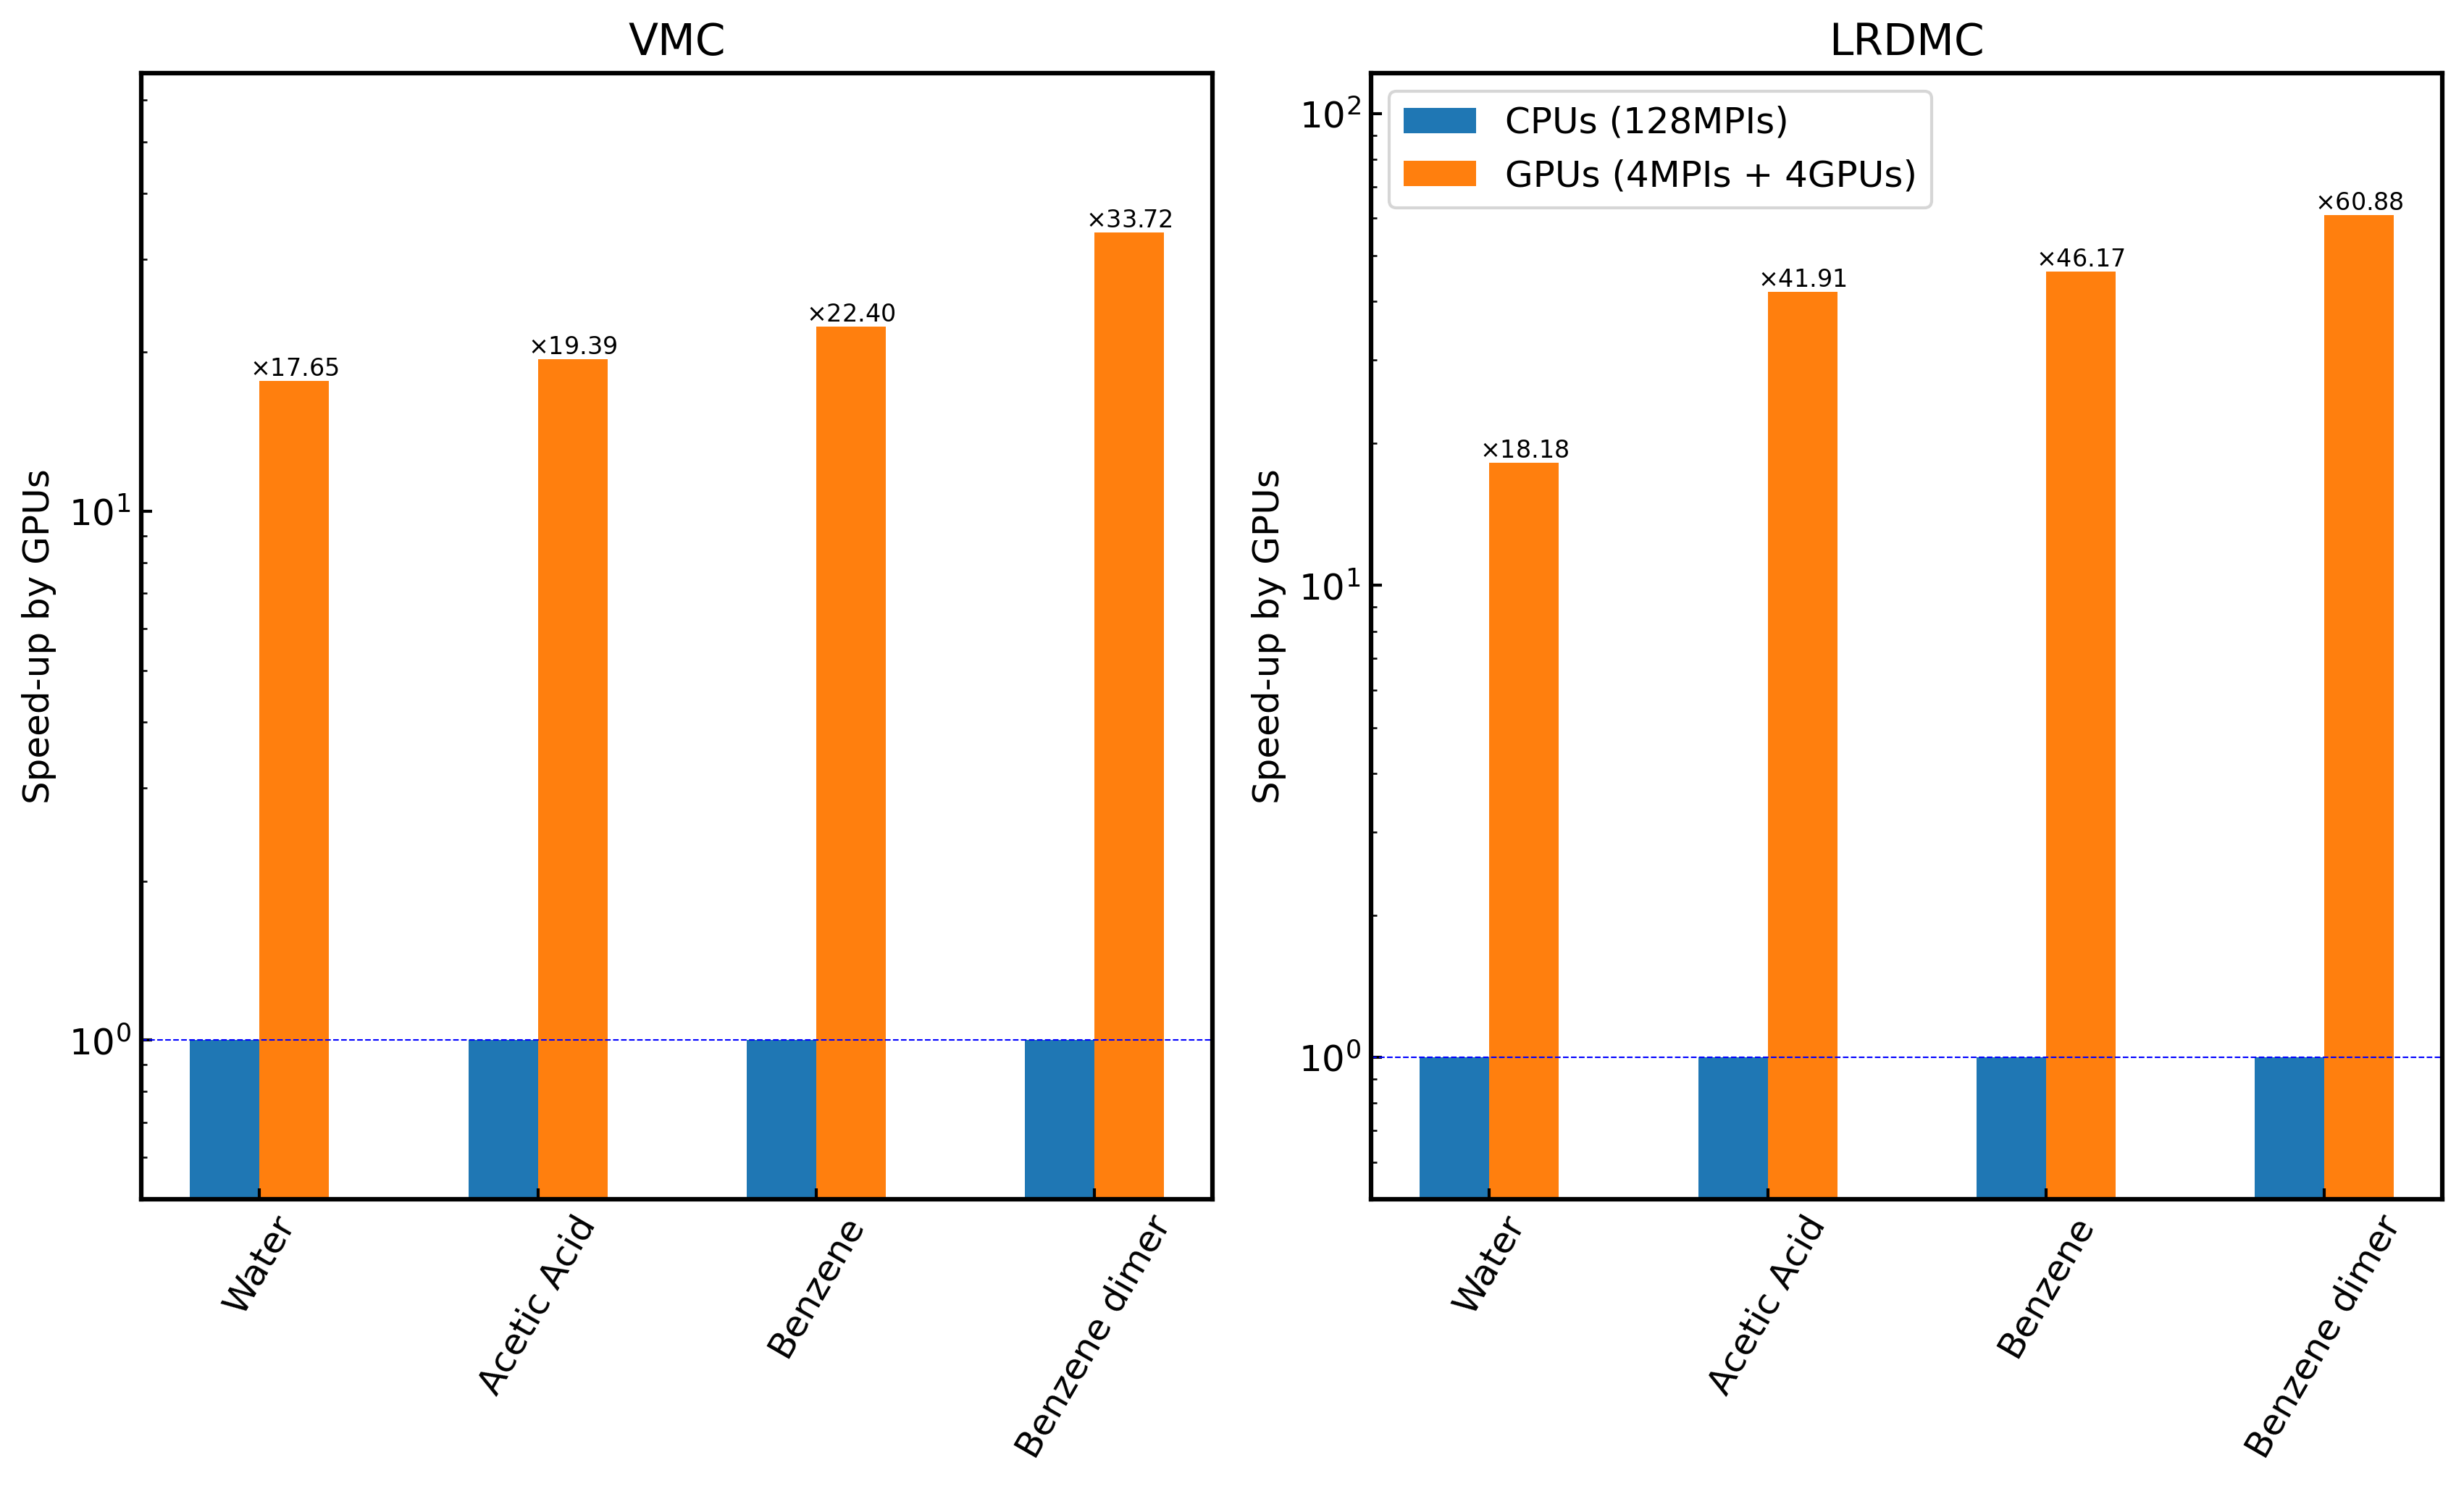

In [189]:
# figure
fig = plt.figure(figsize=(11.5, 7), facecolor="white", dpi=300, tight_layout=True)
# fig.suptitle(
#    rf"Benchmark of VMC/LRDMC implemented in jQMC, measured on Xeon Platinum 8490H (60 cores) $\times$ 2 + NVIDIA H100 (Hopper) $\times$ 4",
#    fontsize=14,
# )

# VMC
ax1 = fig.add_subplot(1, 2, 1)

# labels
x_index = np.arange(len(mol_list))
ax1.set_xticks(x_index)
ax1.set_xticklabels(mol_label2_list, rotation=60)
ax1.set_yscale("log")
ax1.set_ylabel("Speed-up by GPUs")
ax1.set_title("VMC")

# plot
width = 0.25
ax1.axhline(1.0, color="b", ls="--", lw=0.5)
ax1.bar(x_index - 0.5 * width, speed_up_jqmc_vmc_cpu, width=width, label="CPU")
ax1.bar(x_index + 0.5 * width, speed_up_jqmc_vmc_gpu, width=width, label="GPU")
ax1.set_ylim(0.5, np.max(speed_up_jqmc_vmc_gpu) * 2.0)

for i, (x, cpu_val, gpu_val) in enumerate(zip(x_index, speed_up_jqmc_vmc_cpu, speed_up_jqmc_vmc_gpu)):
    ax1.text(x + 0.5 * width, gpu_val, rf"$\times${gpu_val:.2f}", ha="center", va="bottom", fontsize=8)

# LRDMC
ax2 = fig.add_subplot(1, 2, 2)

# labels
x_index = np.arange(len(mol_list))
ax2.set_xticks(x_index)
ax2.set_xticklabels(mol_label2_list, rotation=60)
ax2.set_yscale("log")
ax2.set_ylabel("Speed-up by GPUs")
ax2.set_title("LRDMC")

# plot
width = 0.25
ax2.axhline(1.0, color="b", ls="--", lw=0.5)
ax2.bar(x_index - 0.5 * width, speed_up_jqmc_lrdmc_cpu, width=width, label="CPUs (128MPIs)")
ax2.bar(x_index + 0.5 * width, speed_up_jqmc_lrdmc_gpu, width=width, label="GPUs (4MPIs + 4GPUs)")
ax2.set_ylim(0.5, np.max(speed_up_jqmc_lrdmc_gpu) * 2.0)

for i, (x, cpu_val, gpu_val) in enumerate(zip(x_index, speed_up_jqmc_lrdmc_cpu, speed_up_jqmc_lrdmc_gpu)):
    ax2.text(x + 0.5 * width, gpu_val, rf"$\times${gpu_val:.2f}", ha="center", va="bottom", fontsize=8)

plt.legend()
plt.savefig(f"jqmc_summary_VMC_LRDMC_benchmark.jpg")
plt.show()